In [24]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
from pandas import to_datetime
import seaborn as sn
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr, iqr

In [25]:
customer_indicators = pd.read_csv("../../indicators.csv", index_col=0)
customer_indicators

,I,Iu,spending,Imax,avg_bought,baskets,E
CustomerID,,,,,,,
12347.0,0.108021,0.059890,0.124483,0.217940,0.019291,0.031579,0.628584
12348.0,0.002658,0.003964,0.071554,0.002658,0.274122,0.000000,0.000000
12349.0,0.307641,0.311199,0.368923,0.307641,0.023277,0.000000,0.585006
12350.0,0.112957,0.073340,0.081727,0.112957,0.008866,0.000000,0.393407
12352.0,0.044423,0.037944,0.064072,0.067110,0.033188,0.031579,0.551425
...,...,...,...,...,...,...,...
18280.0,0.028571,0.048563,0.053783,0.028571,0.030539,0.000000,0.324265
18281.0,0.033223,0.023786,0.013787,0.033223,0.005147,0.000000,0.230642
18282.0,0.016279,0.021308,0.020487,0.017276,0.025711,0.005263,0.299490


In [26]:
def target_label(row):
    first_third = customer_indicators["spending"].quantile(0.33)
    second_third = customer_indicators["spending"].quantile(0.66)
    if (row["spending"] <= first_third):
        return 1
    elif (row["spending"] > first_third and row["spending"] <= second_third):
        return 2
    return 3

customer_indicators["label"] = customer_indicators.apply(target_label, axis=1)

In [27]:
from sklearn.model_selection import train_test_split

customer_indicatorsForClass=customer_indicators.copy()

#extract and remove original label values
originalLabel=customer_indicatorsForClass["label"].values
customer_indicatorsForClass=customer_indicatorsForClass.drop(columns=['label'])
#generate training and test set
train_set, test_set, train_label, test_label = train_test_split(
    customer_indicatorsForClass,
    originalLabel,
    stratify = originalLabel,
    test_size=0.40
)

In [28]:
print(train_set)
print(train_label.shape)
print(test_set)
print(test_label.shape)

                   I        Iu  spending      Imax  avg_bought   baskets  \
CustomerID                                                                 
15530.0     0.080897  0.094400  0.090089  0.148837    0.019999  0.015789   
15907.0     0.069989  0.108028  0.046092  0.114286    0.009893  0.010526   
12833.0     0.063123  0.088206  0.094164  0.063123    0.031833  0.000000   
14400.0     0.107641  0.088206  0.082265  0.107641    0.011616  0.000000   
14054.0     0.039867  0.028741  0.027412  0.039867    0.008060  0.000000   
...              ...       ...       ...       ...         ...       ...   
15050.0     0.087043  0.095639  0.113501  0.119601    0.023033  0.005263   
14184.0     0.083056  0.117939  0.135249  0.083056    0.035055  0.000000   
15671.0     0.061794  0.039643  0.055579  0.124252    0.015246  0.021053   
13321.0     0.022591  0.018831  0.042760  0.022591    0.023401  0.000000   
15948.0     0.133555  0.110505  0.131294  0.183389    0.016614  0.005263   

           

Funzione di grid search dei migliori parametri di un algoritmo:

In [29]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, grid_params, model, jobs = 1):
    gs = GridSearchCV(
        model,
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = jobs
    )
    gs_result = gs.fit(X, y)
    return gs_result.best_score_, gs_result.best_estimator_, gs_result.best_params_

Funzione di plotting della matrice di confusione con seaborn (per il salvataggio su disco):

In [7]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    ax = sn.heatmap(conf, annot=True)
    ax.set(xlabel = "Predicted label", ylabel = "True label")

# K-Nearest Neighbors

Si usa l'implementazione contenuta in SciKit-Learn, validando i parametri con una grid search.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

grid_params = {
    "n_neighbors": list(range(1, 10)),
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "metric": ["euclidean", "manhattan", "minkowski"]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    KNeighborsClassifier()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed:   21.0s finished


0.8921939981624253

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=6,
                     weights='distance')

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 6,
 'weights': 'distance'}

Usiamo i parametri trovati per eseguire il training sull'intero training set e la predizione dei risultati

In [9]:
knn = KNeighborsClassifier(**best_params)
knn.fit(train_set, train_label)
pred_label = knn.predict(test_set)

Verifichiamo i risultati attraverso la matrice di confusione:

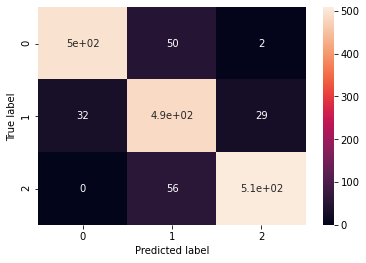

In [10]:
plot_confusion_matrix(test_label, pred_label)


Facciamo restituire un report della precisione, del recall e dello f1-score:

In [11]:
from sklearn.metrics import classification_report

print(classification_report(test_label, pred_label))

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       547
           2       0.82      0.89      0.85       547
           3       0.94      0.90      0.92       564

    accuracy                           0.90      1658
   macro avg       0.90      0.90      0.90      1658
weighted avg       0.90      0.90      0.90      1658



# Support Vector Machine

Esistono molte implementazioni di Support Vector Machine dedicate a problemi di classificazione. 

## Support Vector Classification (`SVC`)

In [12]:
from sklearn.svm import SVC

C_values = [2**(i) for i in range(-5, 15, 2)]

gamma_values = [2**(i) for i in range(-15, 3, 2)] + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "C": C_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    SVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 880 candidates, totalling 2640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2640 out of 2640 | elapsed:  5.5min finished


0.9927604218263473

SVC(C=8192, gamma=0.5)

{'C': 8192, 'gamma': 0.5, 'kernel': 'rbf', 'shrinking': True}

Si indaga ulteriormente con un'altra 3-fold validation con C che varia da 2^12 a 2^13 e con gamma che varia da 

In [13]:
from sklearn.svm import SVC

C_values = np.linspace(2**12, 2**13, 11)

gamma_values = list(np.linspace(2**(-15), 2**(-14), 11)) + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "C": C_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    SVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 1144 candidates, totalling 3432 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3432 out of 3432 | elapsed: 12.3min finished


0.9919562400812728

SVC(C=6144.0, gamma=3.0517578125e-05, kernel='linear')

{'C': 6144.0, 'gamma': 3.0517578125e-05, 'kernel': 'linear', 'shrinking': True}

In [14]:
svc = SVC(**best_params)
svc.fit(train_set, train_label)
pred_label = svc.predict(test_set)

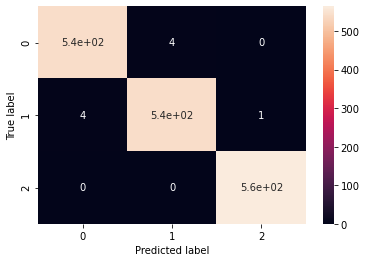

In [15]:
plot_confusion_matrix(test_label, pred_label)

In [16]:
from sklearn.metrics import classification_report

print(classification_report(test_label, pred_label))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       547
           2       0.99      0.99      0.99       547
           3       1.00      1.00      1.00       564

    accuracy                           0.99      1658
   macro avg       0.99      0.99      0.99      1658
weighted avg       0.99      0.99      0.99      1658



## $\nu$ - Support Vector Classification (`NuSVC`)

Implementazione che prende come iperparametro un limite inferiore alla percentuale di vettori di supporto.

In [17]:
from sklearn.svm import NuSVC

nu_values = np.linspace(0.1, 1, 13)

gamma_values = [2**(i) for i in range(-15, 3, 2)] + ["auto", "scale"]

grid_params = {
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "nu": nu_values,
    "gamma": gamma_values,
    "shrinking": [True, False]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    NuSVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 1144 candidates, totalling 3432 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3432 out of 3432 | elapsed:  4.0min finished


0.9818971696299016

NuSVC(gamma=3.0517578125e-05, kernel='linear', nu=0.1)

{'gamma': 3.0517578125e-05, 'kernel': 'linear', 'nu': 0.1, 'shrinking': True}

Per completezza si espande la grid search per il parametro $\gamma$ da $2^{-15}$ a $2^{-14}$, analogamente al punto precedente.

In [18]:
from sklearn.svm import NuSVC

nu_values = [0.1]

gamma_values = list(np.linspace(2**(-15), 2**(-14), 11)) + ["auto", "scale"]

grid_params = {
    "kernel": ["linear"],
    "nu": nu_values,
    "gamma": gamma_values,
    "shrinking": [True]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    NuSVC()
)
display(best_score)
display(best_estimator)
display(best_params)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Fitting 3 folds for each of 13 candidates, totalling 39 fits
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    1.3s finished


0.9818971696299016

NuSVC(gamma=3.0517578125e-05, kernel='linear', nu=0.1)

{'gamma': 3.0517578125e-05, 'kernel': 'linear', 'nu': 0.1, 'shrinking': True}

Si usano tali parametri per il training:

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       547
           2       0.97      0.99      0.98       547
           3       1.00      0.99      0.99       564

    accuracy                           0.99      1658
   macro avg       0.99      0.99      0.99      1658
weighted avg       0.99      0.99      0.99      1658



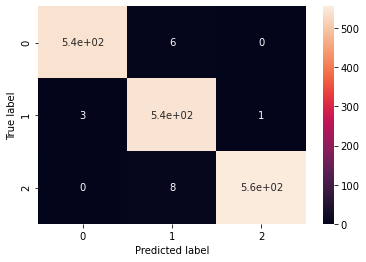

In [19]:
nu_svc = NuSVC(**best_params)
nu_svc.fit(train_set, train_label)
pred_label = nu_svc.predict(test_set)
plot_confusion_matrix(test_label, pred_label)
plt.savefig("./nu-svc-conf.png")
print(classification_report(test_label, pred_label))

## Linear Support Vector Classification (`LinearSVC`)

Implementazione di SVM con kernel lineare, basata su `liblinear`, che rende possibile maggiore flessibilità nella scelta della funzione di loss.

Dato che il parametro $C$ è stato validato nell'uso delle precedenti implementazioni, lo si fissa e si procede alla cross-validation al variare di tutti gli altri iperparametri:

In [20]:
from sklearn.svm import LinearSVC

grid_params = {
    "C": [7372.8],
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "dual": [True, False],
    "multi_class": ["ovr", "crammer_singer"],
    "fit_intercept": [True, False],
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    LinearSVC()
)
display(best_score)
display(best_estimator)
display(best_params)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.9min finished


0.9919557544642771

LinearSVC(C=7372.8, multi_class='crammer_singer', penalty='l1')

{'C': 7372.8,
 'dual': True,
 'fit_intercept': True,
 'loss': 'squared_hinge',
 'multi_class': 'crammer_singer',
 'penalty': 'l1'}

C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

           1       0.99      0.99      0.99       547
           2       0.99      0.99      0.99       547
           3       1.00      1.00      1.00       564

    accuracy                           1.00      1658
   macro avg       1.00      1.00      1.00      1658
weighted avg       1.00      1.00      1.00      1658



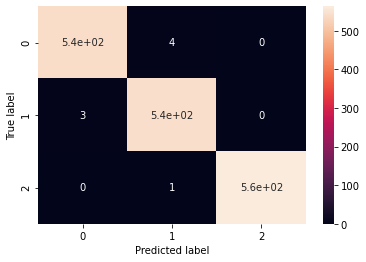

In [21]:
linear_svc = LinearSVC(**best_params)
linear_svc.fit(train_set, train_label)
pred_label = linear_svc.predict(test_set)
plot_confusion_matrix(test_label, pred_label)
plt.savefig("./linear-svc-conf.png")
print(classification_report(test_label, pred_label))

# Ridge Classifier

Si testa l'algoritmo di classificazione basato su Ridge Regression al variare del parametro della Regolarizzazione di Tickhonov.

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   13.5s finished


0.7755546231709237

{'alpha': 0.03333333333333333,
 'fit_intercept': True,
 'normalize': True,
 'solver': 'sparse_cg'}

              precision    recall  f1-score   support

           1       0.70      0.85      0.77       547
           2       0.77      0.54      0.64       547
           3       0.92      0.98      0.95       564

    accuracy                           0.79      1658
   macro avg       0.79      0.79      0.78      1658
weighted avg       0.80      0.79      0.78      1658



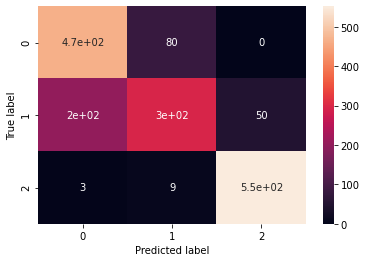

In [29]:
from sklearn.linear_model import RidgeClassifier

grid_params = {
    "alpha": np.linspace(0, 0.1, 10),
    "fit_intercept": [True, False],
    "normalize": [True, False],
    "solver": ["svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
}

best_score, best_estimator, best_params = grid_search(
    train_set,
    train_label,
    grid_params,
    RidgeClassifier()
)
display(best_score)
display(best_params)

ridge = RidgeClassifier(**best_params)
ridge.fit(train_set, train_label)
pred_label = ridge.predict(test_set)
plot_confusion_matrix(test_label, pred_label)
plt.savefig("./ridge-conf.png")
print(classification_report(test_label, pred_label))